In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


2025-12-06 16:40:43.660310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765039243.861626      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765039243.912826      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
DATASET_PATH = "/kaggle/input/osteoporosis-dataset/Combined Dataset/Combined Dataset"

IMG_SIZE = 300   # EfficientNetB3 expects 300x300
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 25
SEED = 42

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.10,
    shear_range=0.08,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=False,      # usually not for X-rays; keep false
    fill_mode="nearest",
    validation_split=0.20
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)


In [5]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED
)

# Print mapping to double-check folder->index mapping
print("Class indices:", train_generator.class_indices)
classes = list(train_generator.class_indices.keys())


Found 2273 images belonging to 3 classes.
Found 566 images belonging to 3 classes.
Class indices: {'normal': 0, 'osteopenia': 1, 'osteoprosis': 2}


In [6]:
# Compute class weights from training generator labels
train_labels = train_generator.classes  # numeric labels corresponding to folder order
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights_dict)


Class weights: {0: 0.7975438596491228, 1: 1.9730902777777777, 2: 0.8068867589634363}


# BUILDING THE EFFICIENTNET-B3 MODEL

In [7]:
# Build model (EfficientNetB3 backbone)
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)

# Freeze the early layers, fine-tune later layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze top blocks (you can tune how many layers to unfreeze)
# We'll unfreeze the last convolutional block of the backbone for better fine-tuning:
for layer in base_model.layers[-100:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()


I0000 00:00:1765039396.170612      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765039396.171208      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,788,146 (41.15 MB)

 Trainable params: 7,766,623 (29.63 MB)

 Non-trainable params: 3,021,523 (11.53 MB)

# COMPILE & CALLBACKS

In [9]:
LR = 1e-4
optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoint = ModelCheckpoint(
    "best_efficientnetb3.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, earlystop]


# Training

In [10]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict,   # optional but helpful if imbalance
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)
I0000 00:00:1765039492.838771     131 service.cc:148] XLA service 0x7e5b54005b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765039492.839674     131 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765039492.839695     131 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765039497.056520     131 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1765039505.092024     131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765039505.238504     131 gpu_timer.cc:82] Delay kernel

  1/143 ━━━━━━━━━━━━━━━━━━━━ 2:06:25 53s/step - accuracy: 0.1250 - loss: 1.3251

I0000 00:00:1765039519.830920     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.3709 - loss: 1.1289
Epoch 1: val_accuracy improved from -inf to 0.16784, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.3708 - loss: 1.1289 - val_accuracy: 0.1678 - val_loss: 1.1666 - learning_rate: 1.0000e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.3914 - loss: 1.0804
Epoch 2: val_accuracy improved from 0.16784 to 0.41343, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 710ms/step - accuracy: 0.3916 - loss: 1.0803 - val_accuracy: 0.4134 - val_loss: 1.0651 - learning_rate: 1.0000e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.4127 - loss: 1.0414
Epoch 3: val_accuracy improved from 0.41343 to 0.52297, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 672ms/step - accuracy: 0.4128 - loss: 1.0413 - val_accuracy: 0.5230 - val_loss: 1.1295 - learning_rate: 1.0000e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.4455 - loss: 1.0122
Epoch 4: val_accuracy improved from 0.52297 to 0.52650, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 680ms/step - accuracy: 0.4456 - loss: 1.0121 - val_accuracy: 0.5265 - val_loss: 1.0678 - learning_rate: 1.0000e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.4997 - loss: 0.9579
Epoch 5: val_accuracy improved from 0.52650 to 0.57067, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 700ms/step - accuracy: 0.4996 - loss: 0.9579 - val_accuracy: 0.5707 - val_loss: 0.9280 - learning_rate: 1.0000e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5123 - loss: 0.9246
Epoch 6: val_accuracy did not improve from 0.57067
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 670ms/step - accuracy: 0.5123 - loss: 0.9246 - val_accuracy: 0.5548 - val_loss: 0.9198 - learning_rate: 1.0000e-04
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.5157 - loss: 0.8902
Epoch 7: val_accuracy improved from 0.57067 to 0.60071, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 728ms/step - accuracy: 0.5158 - loss: 0.8900 - val_accuracy: 0.6007 - val_loss: 0.9481 - learning_rate: 1.0000e-04
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5547 - loss: 0.8691
Epoch 8: val_accuracy did not improve from 0.60071
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 702ms/step - accuracy: 0.5547 - loss: 0.8690 - val_accuracy: 0.4735 - val_loss: 1.1675 - learning_rate: 1.0000e-04
Epoch 9/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.5220 - loss: 0.8795
Epoch 9: val_accuracy did not improve from 0.60071
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 706ms/step - accuracy: 0.5221 - loss: 0.8794 - val_accuracy: 0.6007 - val_loss: 0.8404 - learning_rate: 1.0000e-04
Epoch 10/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.5453 - loss: 0.8316
Epoch 10: val_accuracy improved from 0.60071 to 0.62721, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 710ms/step - accuracy: 0.5454 - loss: 0.8314 - val_accuracy: 0.6272 - val_loss: 0.9975 - learning_rate: 1.0000e-04
Epoch 11/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.5830 - loss: 0.7767
Epoch 11: val_accuracy did not improve from 0.62721
143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 687ms/step - accuracy: 0.5829 - loss: 0.7768 - val_accuracy: 0.5636 - val_loss: 0.9420 - learning_rate: 1.0000e-04
Epoch 12/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.5899 - loss: 0.8145
Epoch 12: val_accuracy did not improve from 0.62721

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 715ms/step - accuracy: 0.5898 - loss: 0.8146 - val_accuracy: 0.5371 - val_loss: 0.9384 - learning_rate: 1.0000e-04
Epoch 13/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5851 - loss: 0.7791
Epoch 13: val_accuracy improved from 0.62721 to 0.63074, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 709ms/step - accuracy: 0.5852 - loss: 0.7790 - val_accuracy: 0.6307 - val_loss: 0.9198 - learning_rate: 5.0000e-05
Epoch 14/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.6001 - loss: 0.7367
Epoch 14: val_accuracy did not improve from 0.63074
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 675ms/step - accuracy: 0.6001 - loss: 0.7368 - val_accuracy: 0.6201 - val_loss: 0.8978 - learning_rate: 5.0000e-05
Epoch 15/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6030 - loss: 0.7343
Epoch 15: val_accuracy improved from 0.63074 to 0.63781, saving model to best_efficientnetb3.h5



Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 720ms/step - accuracy: 0.6030 - loss: 0.7343 - val_accuracy: 0.6378 - val_loss: 0.9211 - learning_rate: 5.0000e-05
Epoch 16/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.6160 - loss: 0.7451
Epoch 16: val_accuracy did not improve from 0.63781
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 692ms/step - accuracy: 0.6159 - loss: 0.7450 - val_accuracy: 0.5936 - val_loss: 0.8880 - learning_rate: 2.5000e-05
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 9.


In [12]:
# ============================================
# SUPPRESS ALL COMMON WARNINGS (CLEAN OUTPUT)
# ============================================

import os
import warnings
import logging

# 1. Suppress Python warnings
warnings.filterwarnings("ignore")

# 2. Suppress TensorFlow INFO & WARNING messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

# 3. Suppress TensorFlow deprecation warnings
tf_logger = logging.getLogger("tensorflow")
tf_logger.setLevel(logging.ERROR)

# 4. Suppress matplotlib warnings (optional)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

print("✅ All warnings suppressed successfully!")


✅ All warnings suppressed successfully!


TensorFlow: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Found 2273 images belonging to 3 classes.
Found 566 images belonging to 3 classes.

Class mapping: {'normal': 0, 'osteopenia': 1, 'osteoprosis': 2}

Class Weights: {0: 0.7975438596491228, 1: 1.9730902777777777, 2: 0.8068867589634363}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 300, 300,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 300, 300,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 300, 300,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,788,146 (41.15 MB)

 Trainable params: 8,398,081 (32.04 MB)

 Non-trainable params: 2,390,065 (9.12 MB)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.3939 - loss: 1.0917
Epoch 1: val_accuracy improved from -inf to 0.16784, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 175s 874ms/step - accuracy: 0.3941 - loss: 1.0913 - val_accuracy: 0.1678 - val_loss: 1.1580 - learning_rate: 1.0000e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5035 - loss: 0.9469
Epoch 2: val_accuracy improved from 0.16784 to 0.42580, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 660ms/step - accuracy: 0.5036 - loss: 0.9466 - val_accuracy: 0.4258 - val_loss: 1.1584 - learning_rate: 1.0000e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.5483 - loss: 0.8545
Epoch 3: val_accuracy did not improve from 0.42580
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 659ms/step - accuracy: 0.5484 - loss: 0.8545 - val_accuracy: 0.3922 - val_loss: 1.2198 - learning_rate: 1.0000e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.5728 - loss: 0.8248
Epoch 4: val_accuracy improved from 0.42580 to 0.57597, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 644ms/step - accuracy: 0.5729 - loss: 0.8246 - val_accuracy: 0.5760 - val_loss: 0.9261 - learning_rate: 1.0000e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.6182 - loss: 0.7693
Epoch 5: val_accuracy improved from 0.57597 to 0.59894, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 639ms/step - accuracy: 0.6182 - loss: 0.7691 - val_accuracy: 0.5989 - val_loss: 0.8721 - learning_rate: 1.0000e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.6212 - loss: 0.7157
Epoch 6: val_accuracy did not improve from 0.59894
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 618ms/step - accuracy: 0.6212 - loss: 0.7157 - val_accuracy: 0.5565 - val_loss: 0.9474 - learning_rate: 1.0000e-04
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.6555 - loss: 0.6773
Epoch 7: val_accuracy improved from 0.59894 to 0.62191, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 697ms/step - accuracy: 0.6554 - loss: 0.6775 - val_accuracy: 0.6219 - val_loss: 0.8931 - learning_rate: 1.0000e-04
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.6324 - loss: 0.6923
Epoch 8: val_accuracy did not improve from 0.62191

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 636ms/step - accuracy: 0.6324 - loss: 0.6923 - val_accuracy: 0.6184 - val_loss: 0.8974 - learning_rate: 1.0000e-04
Epoch 9/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.6376 - loss: 0.7038
Epoch 9: val_accuracy improved from 0.62191 to 0.63428, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 635ms/step - accuracy: 0.6377 - loss: 0.7037 - val_accuracy: 0.6343 - val_loss: 0.8259 - learning_rate: 5.0000e-05
Epoch 10/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.6701 - loss: 0.6448
Epoch 10: val_accuracy did not improve from 0.63428
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 620ms/step - accuracy: 0.6700 - loss: 0.6449 - val_accuracy: 0.5901 - val_loss: 0.8566 - learning_rate: 5.0000e-05
Epoch 11/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.6509 - loss: 0.6373
Epoch 11: val_accuracy did not improve from 0.63428
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 637ms/step - accuracy: 0.6509 - loss: 0.6375 - val_accuracy: 0.6060 - val_loss: 0.8481 - learning_rate: 5.0000e-05
Epoch 12/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6559 - loss: 0.6563
Epoch 12: val_accuracy did not improve from 0.63428
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 627ms/step - accuracy: 0.6559 - loss: 0.6564 - val_accuracy: 0.6219 - val_loss: 0.8014 - learning_ra

143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 629ms/step - accuracy: 0.6844 - loss: 0.6336 - val_accuracy: 0.6502 - val_loss: 0.7918 - learning_rate: 5.0000e-05
Epoch 15/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6710 - loss: 0.6499
Epoch 15: val_accuracy did not improve from 0.65018
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 694ms/step - accuracy: 0.6712 - loss: 0.6497 - val_accuracy: 0.6219 - val_loss: 0.8245 - learning_rate: 5.0000e-05
Epoch 16/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6785 - loss: 0.6336
Epoch 16: val_accuracy did not improve from 0.65018
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - accuracy: 0.6786 - loss: 0.6336 - val_accuracy: 0.6166 - val_loss: 0.8191 - learning_rate: 5.0000e-05
Epoch 17/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6838 - loss: 0.5996
Epoch 17: val_accuracy did not improve from 0.65018
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 646ms/step - accuracy: 0.6837 - loss: 0.5997 - val_accuracy: 0.6484 - val_loss: 0.7916 - learning_r

143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 638ms/step - accuracy: 0.6789 - loss: 0.6327 - val_accuracy: 0.6625 - val_loss: 0.7459 - learning_rate: 5.0000e-05
Epoch 19/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.6752 - loss: 0.6455
Epoch 19: val_accuracy did not improve from 0.66254
143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 712ms/step - accuracy: 0.6753 - loss: 0.6453 - val_accuracy: 0.6201 - val_loss: 0.8659 - learning_rate: 5.0000e-05
Epoch 20/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6859 - loss: 0.6118
Epoch 20: val_accuracy did not improve from 0.66254
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 628ms/step - accuracy: 0.6859 - loss: 0.6119 - val_accuracy: 0.6502 - val_loss: 0.8108 - learning_rate: 5.0000e-05
Epoch 21/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.7045 - loss: 0.5912
Epoch 21: val_accuracy improved from 0.66254 to 0.66431, saving model to best_efficientnetb3.h5



Epoch 21: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 636ms/step - accuracy: 0.7044 - loss: 0.5914 - val_accuracy: 0.6643 - val_loss: 0.7708 - learning_rate: 5.0000e-05
Epoch 22/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7015 - loss: 0.6233
Epoch 22: val_accuracy did not improve from 0.66431
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 621ms/step - accuracy: 0.7015 - loss: 0.6231 - val_accuracy: 0.6608 - val_loss: 0.7606 - learning_rate: 2.5000e-05
Epoch 23/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.7166 - loss: 0.5998
Epoch 23: val_accuracy improved from 0.66431 to 0.66608, saving model to best_efficientnetb3.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 720ms/step - accuracy: 0.7165 - loss: 0.5998 - val_accuracy: 0.6661 - val_loss: 0.7776 - learning_rate: 2.5000e-05
Epoch 24/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.7267 - loss: 0.5640
Epoch 24: val_accuracy did not improve from 0.66608

Epoch 24: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 634ms/step - accuracy: 0.7266 - loss: 0.5641 - val_accuracy: 0.6449 - val_loss: 0.7639 - learning_rate: 2.5000e-05
Epoch 25/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.7227 - loss: 0.5539
Epoch 25: val_accuracy did not improve from 0.66608
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 656ms/step - accuracy: 0.7226 - loss: 0.5541 - val_accuracy: 0.6537 - val_loss: 0.7612 - learning_rate: 1.2500e-05
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 18.


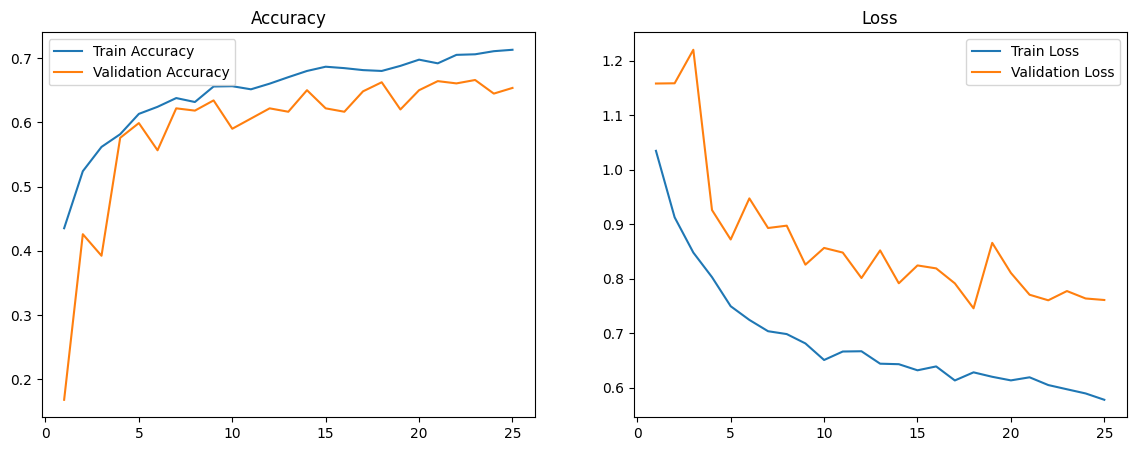

36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 509ms/step


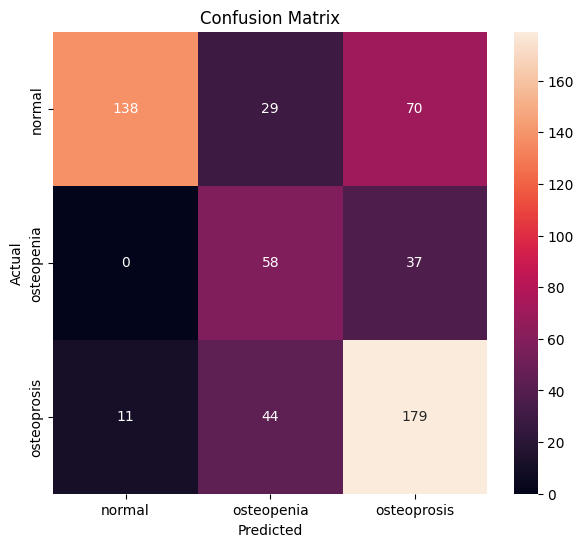


Classification Report:

              precision    recall  f1-score   support

      normal       0.93      0.58      0.72       237
  osteopenia       0.44      0.61      0.51        95
 osteoprosis       0.63      0.76      0.69       234

    accuracy                           0.66       566
   macro avg       0.66      0.65      0.64       566
weighted avg       0.72      0.66      0.67       566


Model saved as efficientnetb3_final_model.h5


In [13]:
# ============================================
# FULL END-TO-END EFFICIENTNET-B3 TRAINING CODE
# FOR OSTEOPOROSIS / OSTEOPENIA / NORMAL
# ============================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


# ============================
# 1. CHECK GPU
# ============================
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


# ============================
# 2. PATH & HYPERPARAMETERS
# ============================
DATASET_PATH = "/kaggle/input/osteoporosis-dataset/Combined Dataset/Combined Dataset"

IMG_SIZE = 300
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 25
SEED = 42


# ============================
# 3. MEDICAL-SAFE AUGMENTATION
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.04,
    height_shift_range=0.04,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest",
    validation_split=0.20
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)


# ============================
# 4. DATA GENERATORS
# ============================
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED
)

print("\nClass mapping:", train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())


# ============================
# 5. CLASS WEIGHTS (IMBALANCE FIX)
# ============================
train_labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights)


# ============================
# 6. BUILD EFFICIENTNET-B3 MODEL
# ============================
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)

# Freeze entire model first
for layer in base_model.layers:
    layer.trainable = False

# ✅ Unfreeze only last 30% layers (SAFE fine-tuning)
unfreeze_from = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[unfreeze_from:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()


# ============================
# 7. COMPILE MODEL
# ============================
optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# ============================
# 8. CALLBACKS
# ============================
checkpoint = ModelCheckpoint(
    "best_efficientnetb3.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, earlystop]


# ============================
# 9. TRAIN MODEL (25 EPOCHS)
# ============================
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


# ============================
# 10. TRAIN vs VALIDATION CURVES
# ============================
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()


# ============================
# 11. CONFUSION MATRIX + REPORT
# ============================
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# ============================
# 12. SAVE FINAL MODEL
# ============================
model.save("efficientnetb3_final_model.h5")
print("\nModel saved as efficientnetb3_final_model.h5")
